In [47]:
from abc import ABC, abstractmethod
import itertools
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import time 


# 1. Block Motion Estimation 

- Full Search Block Motion Estimation agorithm for motion estimation betweeen two consecutive frames. Block size is 16x16, search range is 48x48.
- Test accuracy on middlebury flow dataset


In [42]:
class BlockMatching(ABC):
    @abstractmethod
    def brute_estimate_motion(self):
        pass

class BME(BlockMatching):
    def __init__(self, block_size, search_range, input_frame, target_frame) -> None:
        """
        :paras 
                block_size(int): size of the block
                search_range(int): search range for the block
                input_frame(numpy array): input frame
                target_frame(numpy array): target frame
        """
        self.block_size = block_size
        self.search_range = search_range
        self.input_frame = input_frame
        self.target_frame = target_frame
        self.blocks = None
        self.mv = None
        self.amplitude = None

    #Full Search Algorithm
    def brute_estimate_motion(self):
        """
        :return
                frame(numpy array): frame with motion vectors
        """
        shape = self.input_frame.shape
        #get the blocks' coordinates in the frame
        self.get_blocks()
        #initialize the motion vector and amplitude
        self.mv = [(0,0)]*(len(self.blocks))
        self.amplitude = np.zeros(len(self.blocks))
        
        """
        run the block matching algorithm/searching 
        """
        #searching the block in whole target frame 
        for count,block in enumerate(self.blocks):
            #getting the actual block from coordinates 
            block_i = self.input_frame[block[0]:block[0]+self.block_size, block[1]:block[1]+self.block_size]
            
            #define the frame difference
            frame_difference_min = 1000000

            for i in range(-self.search_range, self.search_range+1):
                for j in range(-self.search_range, self.search_range+1):
                
                    #check if the block is in the frame
                    if not (block[0]+i >= 0 and block[0]+i+self.block_size <= shape[0] and block[1]+j >= 0 and block[1]+j+self.block_size <= shape[1]):
                        continue
                    
                    #new coordinates
                    x = block[0]+i
                    y = block[1]+j

                    #corresponding block in the target frame
                    target_block = self.target_frame[x:x+self.block_size, y:y+self.block_size]

                    #skip if the block is not of same size
                    if target_block.shape != block_i.shape:
                        continue

                    #calculate the frame difference
                    frame_difference = np.sum((block_i - target_block)**2) #MSE
                    if frame_difference < frame_difference_min:
                        #direction 
                        self.mv[count] = (i,j)
                        #amplitude
                        self.amplitude[count] = np.sqrt(i**2 + j**2)
                        frame_difference_min = frame_difference
                    
        #save and plot the motion vectors
        return self.get_frame(), self.draw_motionvectors()
    
    def logarithmic_search(self):
        """
        :return
                frame(numpy array): frame with motion vectors
        """
        
        shape = self.input_frame.shape
        #get the blocks' coordinates in the frame
        self.get_blocks()
        #initialize the motion vector and amplitude
        self.mv = [(0,0)]*(len(self.blocks))
        self.amplitude = np.zeros(len(self.blocks))
        
        """
        run the logarithmic block matching algorithm
        """
        #searching the block in whole target fram 
        for count,block in enumerate(self.blocks):
            #getting the actual block from coordinates 
            block_i = self.input_frame[block[0]:block[0]+self.block_size, block[1]:block[1]+self.block_size]
            #center of the block
            center_coords= (block[0]+self.block_size//2,block[1]+self.block_size//2)

            #initial search locations
            arm_length = np.ceil((self.search_range//2 )/2)
            five_searchlocations = [(center_coords[0],center_coords[1]),
                                    (center_coords[0]+arm_length, center_coords[1]),
                                    (center_coords[0], center_coords[1]+arm_length),
                                    (center_coords[0]-arm_length, center_coords[1]),
                                    (center_coords[0], center_coords[1]-arm_length)
                                    ]
                                    
            track_coords_loss = {}
            #define the frame difference
            frame_difference_min = 1000000

            #iteratively search for the block with minimum frame difference
            while True:
                frame_difference_temp = [100000]*5
                count_temp = 0
                #check if the block is in the frame
                for i,j in five_searchlocations:
                    i, j = int(i), int(j)
                    count_temp += 1

                    #if coordinate already checked and block size constraint - then skip
                    if (i,j) in track_coords_loss.keys():
                        frame_difference_temp[count_temp-1] = track_coords_loss[(i,j)]
                        continue
                    if not (i >= self.block_size//2 and i+self.block_size//2 <= shape[0] and j >= self.block_size//2  and j+self.block_size//2 <= shape[1]):
                        continue
                    
                    #corresponding block in the target frame
                    target_block = self.target_frame[i-self.block_size//2:i+self.block_size//2, j-self.block_size//2:j+self.block_size//2]

                    #calculate the frame difference
                    frame_difference = np.sum((block_i - target_block)**2) #MSE
                    frame_difference_temp[count_temp-1] = frame_difference
                    #update track_coords_loss
                    track_coords_loss[(i,j)] = frame_difference
                
                if count_temp == 5:
                    frame_difference_min = np.min(frame_difference_temp)
                    #select the minimum frame difference location 
                    min_index = np.argmin(frame_difference_temp)
                    #break if no update in min loss location
                    if frame_difference_min == frame_difference_temp[min_index] and min_index == 0:
                        break
                    #update the center coordinate
                    new_center_coords = five_searchlocations[min_index]
                    #update the arm length
                    arm_length = np.ceil(arm_length/2)
                    #print("arm length", arm_length)
                    if arm_length == 0:
                        print("arm length is zero")
                        break
                    #update the five search locations
                    five_searchlocations = [(new_center_coords[0],new_center_coords[1]),
                                            (new_center_coords[0]+arm_length, new_center_coords[1]),
                                            (new_center_coords[0], new_center_coords[1]+arm_length),
                                            (new_center_coords[0]-arm_length, new_center_coords[1]),
                                            (new_center_coords[0], new_center_coords[1]-arm_length)
                                            ]
                                            
            #get the location of minimum frame difference location
            min_index = np.argmin(frame_difference_temp)
            #direction
            self.mv[count] = (int(five_searchlocations[min_index][0]-center_coords[0]),int(five_searchlocations[min_index][1]-center_coords[1]))
            #amplitude
            self.amplitude[count] = np.sqrt((five_searchlocations[min_index][0]-center_coords[0])**2 + (five_searchlocations[min_index][1]-center_coords[1])**2)                
                
        #save and plot the motion vectors
        return self.get_frame(), self.draw_motionvectors()
        
    #helper function for getting blocks' coordinates in a frame
    def get_blocks(self):
        """ 
        :return
                blocks(list): list of blocks' coordinates in the frame; top left corner of the block.
        """
        self.blocks = []
        for i in range(0, self.input_frame.shape[0], self.block_size):
            for j in range(0, self.input_frame.shape[1], self.block_size):
                self.blocks.append((i, j))
        
    #helper function for getting predicted frame from blocks
    def get_frame(self):
        """ 
        :return
                frame(np.array): predicted frame 
        """
        
        frame = self.input_frame.copy()        
        for i, block in enumerate(self.blocks):
            x = block[0]
            y = block[1]

            #original block
            block_ = self.input_frame[x:x+self.block_size, y:y+self.block_size]
            #motion vector
            mv = self.mv[i]
            #new coordinates
            x = x + mv[0]
            y = y + mv[1]
            
            #new lcoation of block in new frame
            frame[x:x+self.block_size, y:y+self.block_size] = block_

        return frame

    def draw_motionvectors(self):
        """ 
        :return
                frame(np.array): frame with motion vectors drawn on it      
        """
        #draw the motion vectors on the frame
        frame = np.zeros(self.input_frame.shape ,dtype=np.uint8)
        for i, block in enumerate(self.blocks):
            #use center of the block as the starting point of the motion vector
            x = block[0] + self.block_size//2
            y = block[1] + self.block_size//2

            #motion vector
            mv = self.mv[i]
            
            #draw the motion vectors
            cv2.arrowedLine(frame, (y, x), (y+mv[1], x+mv[0]), (255, 255, 255), 1)

        return frame
         


#### 1.1 Full Search Block Motion Estimation

time cost 37.11271810531616


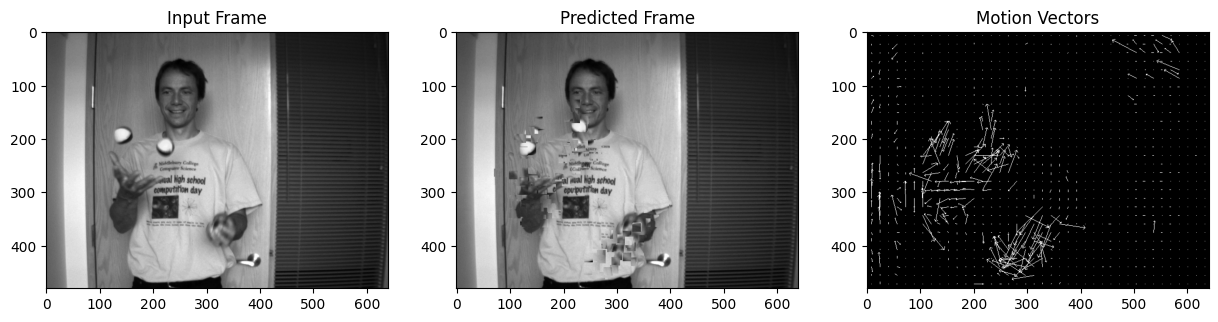

accuracy 0.20426106770833333


In [48]:
#load the frames 
input_frame = cv2.imread('other-data-gray/Beanbags/frame10.png', 0)
target_frame = cv2.imread('other-data-gray/Beanbags/frame11.png', 0)

#set the parameters
block_size = 16
search_range = 48 

#run the block matching algorithm
bme = BME(block_size, search_range, input_frame, target_frame)
time_start = time.time()
predicted_frame, motion_vectors = bme.brute_estimate_motion()
time_end = time.time()
print("time cost", time_end-time_start)

#plot the results
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(input_frame, cmap='gray')
plt.title('Input Frame')
plt.subplot(1,3,2)
plt.imshow(predicted_frame, cmap='gray')
plt.title('Predicted Frame')
plt.subplot(1,3,3)
plt.imshow(motion_vectors, cmap='gray')
plt.title('Motion Vectors')
plt.show()

#accuracy based on ground truth frame 
ground_truth = cv2.imread('./other-gt-interp-gray/Beanbags/frame10i11.png', 0)
print("accuracy", metrics.accuracy_score(ground_truth.flatten(), input_frame.flatten()))


## 2. Logarithmic search. Follow same parametere as above. 

For the given image pair with resolution of (480, 640), time taken by full search algorithm is 37.112 seconds and logarithmic search algorithm is 0.0446 seconds.


time cost 0.04473400115966797


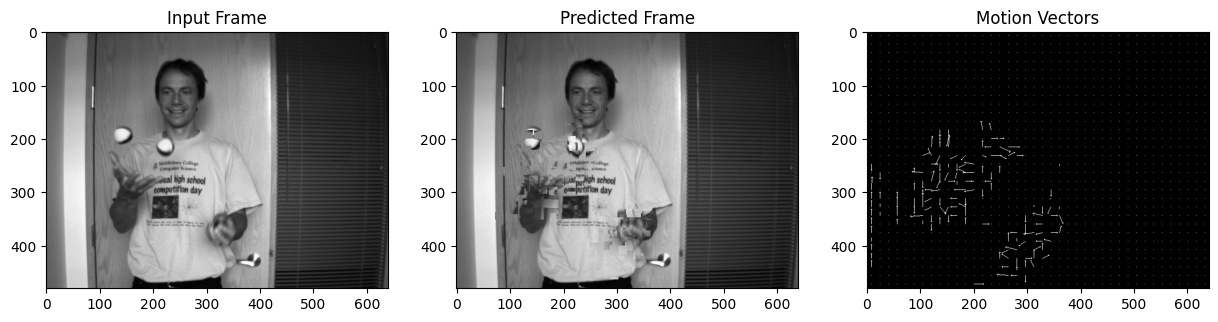

accuracy 0.20426106770833333


In [51]:
#load the frames 
input_frame = cv2.imread('other-data-gray/Beanbags/frame10.png', 0)
target_frame = cv2.imread('other-data-gray/Beanbags/frame11.png', 0)
#input_frame = cv2.imread('frame10.png', 0)
#target_frame = cv2.imread('frame11.png', 0)

#set the parameters
block_size = 16
search_range = 48 

#run the block matching algorithm
bme = BME(block_size, search_range, input_frame, target_frame)
time_start = time.time()
predicted_frame, motion_vectors = bme.logarithmic_search()
time_end = time.time()
print("time cost", time_end-time_start)

#plot the results
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(input_frame, cmap='gray')
plt.title('Input Frame')
plt.subplot(1,3,2)
plt.imshow(predicted_frame, cmap='gray')
plt.title('Predicted Frame')
plt.subplot(1,3,3)
plt.imshow(motion_vectors, cmap='gray')
plt.title('Motion Vectors')
plt.show()

#accuracy based on ground truth frame 
ground_truth = cv2.imread('./other-gt-interp-gray/Beanbags/frame10i11.png', 0)
print("accuracy", metrics.accuracy_score(ground_truth.flatten(), input_frame.flatten()))


### 2.2. Compare the number of computation in two approaches. 

As shown below, the number of computation in logarithmic search is much less than full search. To be exact, in full search the number of computation is more than $1e8$, while in logarithmic search the number of computation is less than $1e6$. Shown below is the comparison of the number of computation in two approaches, Which shows 76 times lesser computation in Logarithmic search for the above used frames. 


In [53]:
#calculate the number of computation steps in both algorithms here
def count_steps_brute(block_size, search_range, input_frame):
    num_blocks = (input_frame.shape[0] // block_size) * (input_frame.shape[1] // block_size)
    num_search_locations = search_range ** 2
    num_steps = num_blocks * num_search_locations * (block_size ** 2)
    return num_steps


def count_steps_logarithmic(block_size, search_range, input_frame):
    num_blocks = (input_frame.shape[0] // block_size) * (input_frame.shape[1] // block_size)
    num_iterations = int(np.log2(search_range)) + 1
    num_steps = num_blocks * num_iterations * 5 * (block_size ** 2)
    return num_steps

#input_frame = np.random.rand(480, 640)
block_size = 16
search_range = 48

num_steps_brute = count_steps_brute(block_size, search_range, input_frame)
num_steps_logarithmic = count_steps_logarithmic(block_size, search_range, input_frame)

print(f"shape of the frame: {input_frame.shape}")
print(f"Number of steps for brute force: {num_steps_brute}")
print(f"Number of steps for logarithmic search: {num_steps_logarithmic}")


shape of the frame: (480, 640)
Number of steps for brute force: 707788800
Number of steps for logarithmic search: 9216000
